In [1]:
# Imports

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import glob

import scipy.signal
import holidays

from interpret.blackbox import LimeTabular
from interpret import show

import shap

import xgboost as xgb

from joblib import dump, load

from pandas.tseries.offsets import MonthEnd

import seaborn as sb

import IPython

In [2]:
# Aux Functions for Solcast and PV data processing

def get_solcast(path):
    file = pd.read_csv(path)
    file.index = pd.to_datetime(file['PeriodEnd'])
    file = file.resample('15T').pad()
    
    return file


def get_pv(path):
    file = pd.read_csv(path)
    file.index = pd.to_datetime(file['datetime_utc'])
    file = file.resample('15T').mean()
    
    return file


def get_solcastPV(df1, df2, ):
    '''
    df1: PV dataframe
    df2: Solcast dataframe
    '''
    
    # Filter both dataframes for 2019 and 2020
    temp_df1 = df1['2019':'2021-04-01']
    temp_df2 = df2['2019':'2021-04-01']
    
    # Check if data is complete. If not, match the smaller indexes
    if temp_df2.shape[0] < temp_df1.shape[0]:
        last_entry = temp_df2.index
        temp_df1 = temp_df1['2019':'{}'.format(temp_df2.index[-1].tz_convert(None))]
    
    
    # Only considering 2019 and 2020 since data is complete for that period
    temp_data = pd.DataFrame({'PV': temp_df1['pv'].values}, index=temp_df1.index)
    for i in np.arange(3, len(temp_df2.columns)):
        temp_data[temp_df2.columns[i]] = temp_df2[temp_df2.columns[i]].shift(-1).values
        
    return temp_data

In [3]:
# Get data and build a dictionary for preprocessing

data = {}

folders = glob.glob('C:/Users/FEEL/Jupyter/ecgomes/upacs_study/data/*08')
for folder in folders:
    # Load each of the files inside the folder
    temp_pv = get_pv('{}/pv.csv'.format(folder))
    temp_solcast = get_solcast('{}/solcast.csv'.format(folder))
    
    # Join the files into a single dataframe
    temp_upac = get_solcastPV(temp_pv, temp_solcast)
    
    temp_name = folder.split('\\')[1]
    data[temp_name] = temp_upac
    
    print('{} date range: {} - {}'.format(temp_name, temp_upac.index[0], temp_upac.index[-1]))

upac08 date range: 2019-01-01 00:00:00 - 2021-04-01 23:45:00


In [4]:
# Aux Functions for adding 2D time information

import datetime

def days_2d(df):
    '''
    Adds 2D time information for single days
    df: dataframe to add the information
    '''
    # Map the index into seconds
    timestamp_s = pd.to_datetime(df.index.values).map(datetime.datetime.timestamp)
    
    # Since we're calculating the cos and sin values from seconds, it's 60 seconds into 60 min into 24 hours per day
    day_calc = 24*60*60
    
    # Calculate the values
    dayx = np.cos((2*np.pi/day_calc) * timestamp_s)
    dayy = np.sin((2*np.pi/day_calc) * timestamp_s)
    
    return dayx, dayy
    

def years_2d(df):
    '''
    Adds 2D time representation throught a year
    df: dataframe to add the information
    '''
    # Add Year Information

    day_year = df.index.dayofyear
    year_constant = 365.2524

    yearx = np.cos((2*np.pi/year_constant) * day_year)
    yeary = np.sin((2*np.pi/year_constant) * day_year)
    
    return yearx, yeary

In [5]:
# Add the 2D time information to the data

for upac in data.keys():
    dayx, dayy = days_2d(data[upac])
    yearx, yeary = years_2d(data[upac])
    
    data[upac]['Day X'] = dayx
    data[upac]['Day Y'] = dayy
    
    data[upac]['Year X'] = yearx
    data[upac]['Year Y'] = yeary

In [6]:
# Split the data for training, validation and testing

data_train = {}
data_val = {}
data_test = {}

for upac in data.keys():
    data_train[upac] = data[upac]['2019']
    data_val[upac] = data[upac]['2020-01':'2020-03']
    data_test[upac] = data[upac]['2020-04':]

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


In [7]:
# Aux Function for filtering data

def filter_by_points(df, frequency='D', num_points=1440, return_dictionary=False):
    
    df_dropped = df.dropna()
    grouper = df_dropped.groupby(pd.Grouper(freq=frequency))
    
    output = 0
    if return_dictionary:
        new_dict = {}
        for i in grouper:
            if (len(i[1]) != num_points):
                pass
            else:
                new_dict[i[0]] = pd.DataFrame(i[1])
        output = new_dict
    else:
        new_df = pd.DataFrame({})
        for i in grouper:
            if (len(i[1]) != num_points):
                pass
            else:
                new_df = new_df.append(pd.DataFrame(i[1]))
        output = new_df
            
    return output

In [8]:
# Filter the data by number of points that should be present in a single day

filtered_train = {}
filtered_val = {}
filtered_test = {}

for upac in data_train.keys():
    filtered_train[upac] = filter_by_points(data_train[upac], frequency='D', num_points=1440/15)
    filtered_val[upac] = filter_by_points(data_val[upac], frequency='D', num_points=1440/15)
    filtered_test[upac] = filter_by_points(data_test[upac], frequency='D', num_points=1440/15)

In [9]:
# Select columns to use

USED_COLUMNS = ['PV', 
                'AirTemp', 
                'CloudOpacity',
                'Ghi', 
                'GtiFixedTilt',
                'Day Y', 'Day X',
                'Year Y', 'Year X']

In [10]:
# Data Normalization
# We don't want to normalize PV so we can capture diferences more easily

# Feature range
# PV - greater than 0
# AirTemp - Unchanged
# Cloud Opacity and Ghi - between 0 and 1
# Day X, Y and Year X and Y - already between -1 and 1

MAX_OPACITY = 100
MAX_GHI = 1023 # max value on the training set
MAX_GTI = 1071 # max value on the training set

normalized_train = {}
normalized_val = {}
normalized_test = {}

for upac in filtered_train.keys():
    normalized_train[upac] = filtered_train[upac][USED_COLUMNS].copy(deep=True)
    normalized_val[upac] = filtered_val[upac][USED_COLUMNS].copy(deep=True)
    normalized_test[upac] = filtered_test[upac][USED_COLUMNS].copy(deep=True)
    
    normalized_train[upac]['CloudOpacity'] = normalized_train[upac]['CloudOpacity'] / MAX_OPACITY
    normalized_val[upac]['CloudOpacity'] = normalized_val[upac]['CloudOpacity'] / MAX_OPACITY
    normalized_test[upac]['CloudOpacity'] = normalized_test[upac]['CloudOpacity'] / MAX_OPACITY
    
    normalized_train[upac]['Ghi'] = normalized_train[upac]['Ghi'] / MAX_GHI
    normalized_val[upac]['Ghi'] = normalized_val[upac]['Ghi'] / MAX_GHI
    normalized_test[upac]['Ghi'] = normalized_test[upac]['Ghi'] / MAX_GHI
    
    normalized_train[upac]['GtiFixedTilt'] = normalized_train[upac]['GtiFixedTilt'] / MAX_GTI
    normalized_val[upac]['GtiFixedTilt'] = normalized_val[upac]['GtiFixedTilt'] / MAX_GTI
    normalized_test[upac]['GtiFixedTilt'] = normalized_test[upac]['GtiFixedTilt'] / MAX_GTI

In [11]:
# Split the data into X and y

X_train = {}
y_train = {}

X_val = {}
y_val = {}

X_test = {}
y_test = {}

for upac in normalized_train.keys():
    trainx = normalized_train[upac].drop('PV', axis=1)
    trainy = normalized_train[upac]['PV']
    valx = normalized_val[upac].drop('PV', axis=1)
    valy = normalized_val[upac]['PV']
    testx = normalized_test[upac].drop('PV', axis=1)
    testy = normalized_test[upac]['PV']
    
    X_train[upac] = trainx
    X_val[upac] = valx
    X_test[upac] = testx
    
    y_train[upac] = trainy
    y_val[upac] = valy
    y_test[upac] = testy

In [20]:
# Get the Tabnet model

from tensorflow.keras.models import load_model

tab_model = load_model('models/tabnet/upac08_gti/Model 10')
tab_yhat = pd.read_csv('results/tabnet/upac08_gti/test/Model 10.csv', index_col='datetime_utc')
tab_yhat.index = pd.to_datetime(tab_yhat.index)

In [21]:
# Test set SHAP values

# Get the SHAP values
kernel_obj = shap.KernelExplainer(tab_model, shap.sample(X_test['upac08'].drop('Ghi', axis=1), 10))

temp_shap = kernel_obj.shap_values(X_test['upac08'].drop('Ghi', axis=1), check_additivity=False)

temp_shap_df = pd.DataFrame(temp_shap[0],
                            columns=X_test['upac08'].drop('Ghi', axis=1).columns,
                            index=X_test['upac08'].index)

  0%|          | 0/34560 [00:00<?, ?it/s]

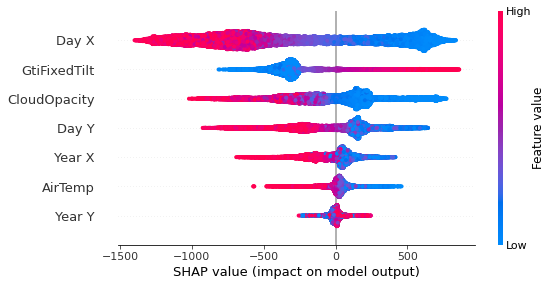

In [23]:
# Test set SHAP plot

shap.summary_plot(temp_shap[0], X_test['upac08'].drop('Ghi', axis=1))

In [24]:
# Add season information to dataframes

def extract_season(df):
    
    date = df.index.month*100 + df.index.day
    df['season'] = (pd.cut(date,[0,321,620,922,1220,1300],
                           labels=['winter','spring','summer','autumn','winter '])
                    #.str.strip()
                   )
    df['season'] = df['season'].str.replace(' ', '')
    df['season'] = df['season'].astype('category')
    
    df['season_int'] = df['season'].cat.codes
    
    return

df_model = temp_shap_df.copy(deep=True)
extract_season(df_model)
df_model.drop('season_int', inplace=True, axis=1)

df_testx = X_test['upac08'].drop('Ghi', axis=1).copy(deep=True)
extract_season(df_testx)
df_testx.drop('season_int', inplace=True, axis=1)

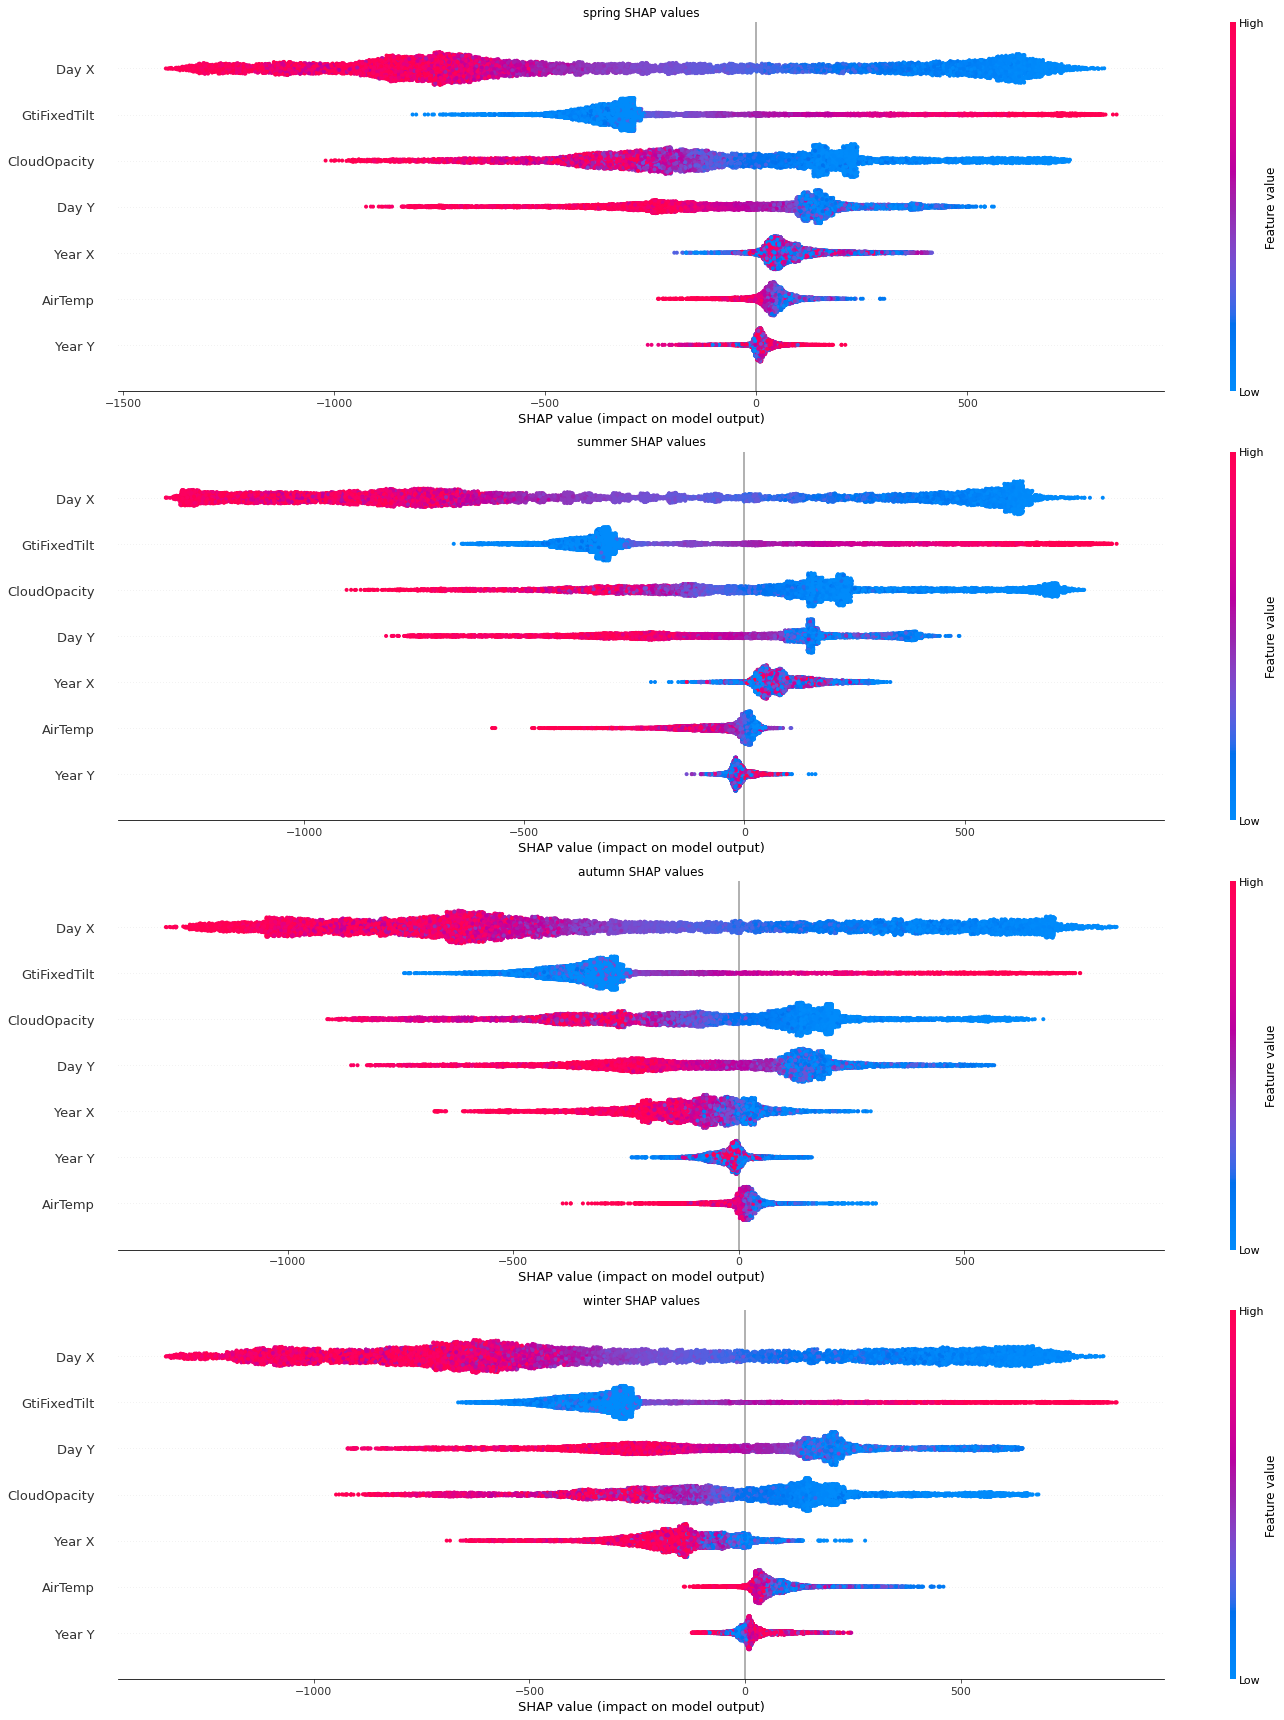

In [25]:
# Model 09 Season analysis

fig = plt.figure(figsize=(20, 24))
current_axs = 0

for season in df_model['season'].unique():
    plt.subplot(4, 1, current_axs+1)
    
    season_shap = df_model.loc[df_model['season'] == season].drop(['season'], axis=1).values
    season_data = df_testx.loc[df_testx['season'] == season].drop(['season'], axis=1)
    
    temp_axs = shap.summary_plot(season_shap, season_data,
                                 plot_size=None, show=False)
    plt.title('{} SHAP values'.format(season))
    current_axs += 1
    
plt.tight_layout()

In [28]:
# Model 10 SHAP values for each season

season_shap = {}
for season in df_model['season'].unique():
    season_shap[season] = np.abs(df_model.loc[df_model['season'] == season].drop('season', axis=1)).describe().loc['mean']
    
season_shap = pd.DataFrame(season_shap)
season_shap = season_shap.reindex(columns=['autumn', 'winter', 'spring', 'summer'])
season_shap = season_shap.transpose()

season_shap = season_shap.reindex(columns=['GtiFixedTilt', 'CloudOpacity', 'Day Y', 'Day X', 'Year Y', 'Year X'])

In [29]:
# Show the mean absolute values of SHAP per season

season_shap

,GtiFixedTilt,CloudOpacity,Day Y,Day X,Year Y,Year X
autumn,336.539739,251.810361,212.351958,555.003867,35.170659,127.865233
winter,346.137592,240.243221,267.456485,562.541748,33.439552,163.317094
spring,348.561943,289.242499,218.888982,619.102072,24.155183,91.097702
summer,349.719285,280.149978,233.619027,638.220861,20.710463,91.135262


In [30]:
# Check the top k SHAP scores

season_shap_th = pd.DataFrame({})

for i in season_shap.index:
    temp_vals = pd.DataFrame(season_shap.loc[i] > season_shap.loc[i]['Day X'] * 0.5)
    temp_vals.columns = [i]
    temp_vals = temp_vals.transpose()
    
    season_shap_th = pd.concat([season_shap_th, temp_vals])
    
season_shap_th

,GtiFixedTilt,CloudOpacity,Day Y,Day X,Year Y,Year X
autumn,True,False,False,True,False,False
winter,True,False,False,True,False,False
spring,True,False,False,True,False,False
summer,True,False,False,True,False,False


In [32]:
# SHAP for the 10 models

explainer_dict = {}
shap_dict = {}
shap_df_dict = {}

# Aux Function for shaping data

def shape_data(data, col, start_hour, end_hour):

    filtered_days = pd.DataFrame({})

    for key in np.arange(len(list(data.keys()))):
        current_key = list(data.keys())[key]
        temp_df = data[current_key].loc[(data[current_key].index.hour >= start_hour) & 
                                        (data[current_key].index.hour <= end_hour)]

        temp_df.index = temp_df.index.strftime('%H:%M')


        filtered_days[current_key] = temp_df[col].values
        filtered_days.index = temp_df.index

    filtered_days = filtered_days.transpose()
    return filtered_days


for i in np.arange(1, 11):
    print('Running Model {:02d}'.format(i))
    temp_model = load_model('models/tabnet/upac08_gti/Model {:02d}'.format(i))
    temp_yhat = pd.read_csv('results/tabnet/upac08_gti/test/Model {:02d}.csv'.format(i), index_col='datetime_utc')
    temp_yhat.index = pd.to_datetime(temp_yhat.index)

    temp_yhat_values = shape_data(filter_by_points(temp_yhat, 
                                                   frequency='D', 
                                                   num_points=1440/15,
                                                   return_dictionary=True), 'PV', 0, 24)
    
    temp_obj = shap.KernelExplainer(temp_model, shap.sample(X_test['upac08'].drop('Ghi', axis=1), 10))

    temp_values = temp_obj.shap_values(X_test['upac08'].drop('Ghi', axis=1), check_additivity=False)

    temp_values_df = pd.DataFrame(temp_values[0],
                                  columns=X_test['upac08'].drop('Ghi', axis=1).columns,
                                  index=X_test['upac08'].drop('Ghi', axis=1).index)
    
    
    explainer_dict['Model {:02d}'.format(i)] = temp_obj
    shap_dict['Model {:02d}'.format(i)] = temp_values
    shap_df_dict['Model {:02d}'.format(i)] = temp_values_df

Running Model 01


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/34560 [00:00<?, ?it/s]

Running Model 02


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/34560 [00:00<?, ?it/s]

Running Model 03


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/34560 [00:00<?, ?it/s]

Running Model 04


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/34560 [00:00<?, ?it/s]

Running Model 05


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/34560 [00:00<?, ?it/s]

Running Model 06


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/34560 [00:00<?, ?it/s]

Running Model 07


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/34560 [00:00<?, ?it/s]

Running Model 08


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/34560 [00:00<?, ?it/s]

Running Model 09


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/34560 [00:00<?, ?it/s]

Running Model 10


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/34560 [00:00<?, ?it/s]

<AxesSubplot:>

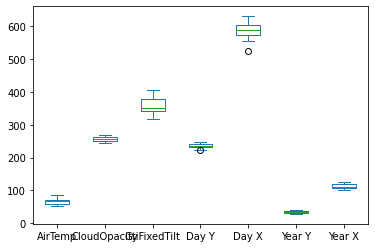

In [33]:
# Show the average of absolute SHAP values for each of the 10 runs

shap_allRuns = pd.DataFrame({})

# Go through each model
for m in shap_df_dict.keys():
    # Get the average of absolute SHAP values
    temp_vals = np.abs(shap_df_dict[m]).describe().loc['mean']
    temp_vals = pd.DataFrame(temp_vals)
    temp_vals.columns = [m]
    temp_vals = temp_vals.transpose()
    
    shap_allRuns = pd.concat([shap_allRuns, temp_vals])
    
shap_allRuns.plot(kind='box')